# Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [27]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


In [35]:
# Actualizar los datos (URL)

url = 'http://cowid.netlify.com/data/full_data.csv'

df = pd.read_csv(url)
df

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,NaN,NaN,1,NaN
1,2020-02-26,Afghanistan,0.0,NaN,1,NaN
2,2020-02-27,Afghanistan,0.0,NaN,1,NaN
3,2020-02-28,Afghanistan,0.0,NaN,1,NaN
4,2020-02-29,Afghanistan,0.0,NaN,1,NaN
5,2020-03-01,Afghanistan,0.0,NaN,1,NaN
6,2020-03-02,Afghanistan,0.0,NaN,1,NaN
7,2020-03-03,Afghanistan,0.0,NaN,1,NaN
8,2020-03-04,Afghanistan,0.0,NaN,1,NaN
9,2020-03-05,Afghanistan,0.0,NaN,1,NaN


Imprimos los resultados y agregamos el numero del dia


In [29]:
df = df[df['location'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
df = df.loc[:,['date','total_cases']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)

df

,date,total_cases
681,60,1
682,61,1
683,62,6
684,63,7
685,64,7
686,65,13
687,66,14
688,67,14
689,68,15
690,69,15


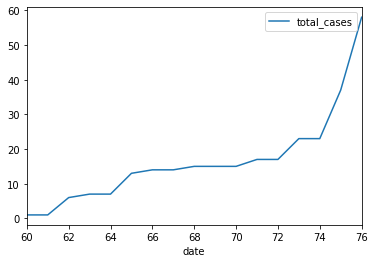

In [30]:
df.plot(x ='date', y='total_cases')

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

Donde Y es el resultado, X es la variable, m la pendiente (o coeficiente) de la recta y b la constante o también conocida como el «punto de corte con el eje Y» en la gráfica (cuando X=0)
Ejemplo
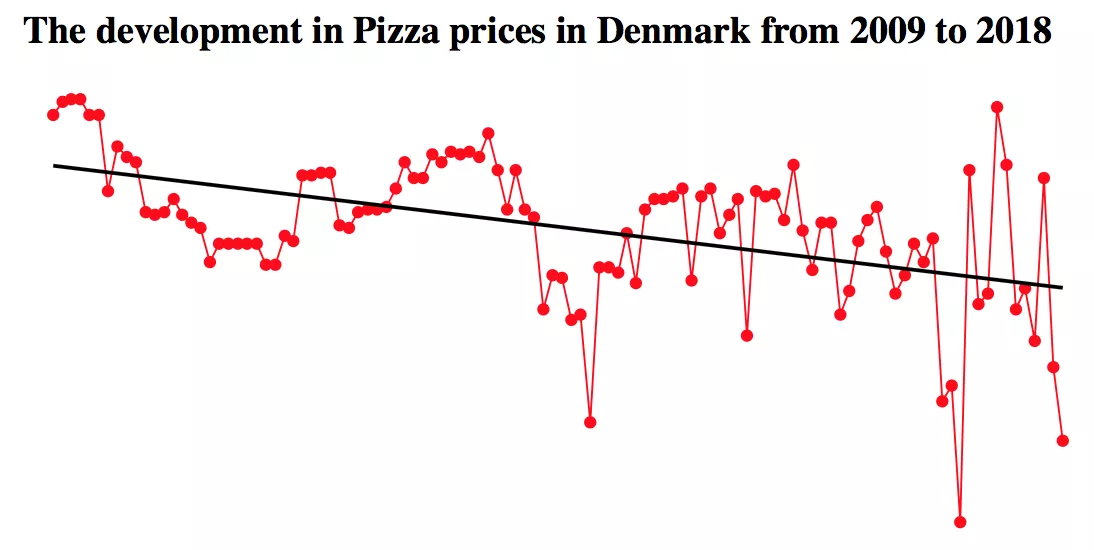

Recordemos que los algoritmos de Machine Learning Supervisados, aprenden por sí mismos y -en este caso- a obtener automáticamente esa «recta» que buscamos con la tendencia de predicción. Para hacerlo se mide el error con respecto a los puntos de entrada y el valor «Y» de salida real.



In [14]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [2.31617647]
Independent term: 
 -140.85294117647058


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [16]:
#Vamos a comprobar:
# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
y_prediccion = regr.predict([[100]])
print(int(y_prediccion))

90


[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]


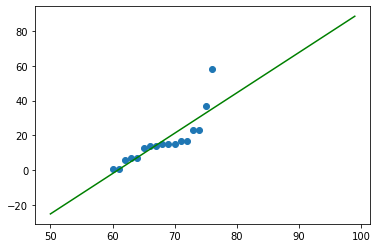

In [21]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(50, 100))
print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='green')
plt.show()



## El modelo logistico

El modelo logístico se ha utilizado ampliamente para describir el crecimiento de una población. Una infección puede describirse como el crecimiento de la población de un agente patógeno, por lo que un modelo logístico parece razonable .
La expresión más genérica de una función logística es:

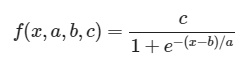

En esta fórmula, tenemos la variable x que es el tiempo y tres parámetros: a, b, c .

- a se refiere a la velocidad de infección
- b es el día en que ocurrieron las infecciones máximas
- c es el número total de personas infectadas registradas al final de la infección
 


A continuacion se puede apreciar un ejemplo de regresion logistica
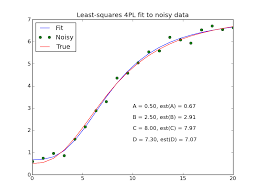

Definamos la función en Python y realicemos elprocedimiento de ajuste de curva utilizado para el crecimiento logístico.

In [31]:
def modelo_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(modelo_logistico,x,y) #Extraemos los valores de los paramatros
print(exp_fit)


(array([-637.69367899,  155.1710206 ]), array([[11872.54041468, -2814.63865054],
       [-2814.63865054,   667.4662425 ]]))


## Graficas

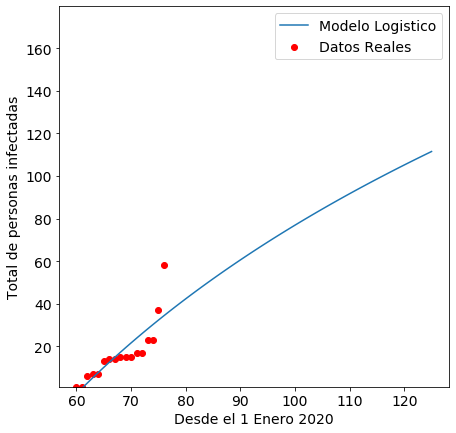

In [34]:
pred_x = list(range(min(x),max(x)+50)) # Predecir 50 dias mas
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*0.9,max(y)*3.1)) # Definir los limites de Y
plt.show()

## Modelo exponencial

Mientras que el modelo logístico describe un crecimiento de infección que se detendrá en el futuro, el modelo exponencial describe un crecimiento de infección imparable . Por ejemplo, si un paciente infecta a 2 pacientes por día, después de 1 día tendremos 2 infecciones, 4 después de 2 días, 8 después de 3 y así sucesivamente.
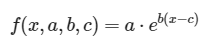

A continuacion se tiene un ejemplo de regresion exponencial
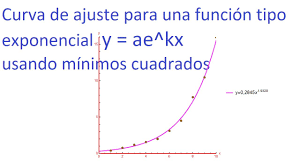

In [ ]:
# Implementar

## Modelo polinomial
Predicción de una variable de respuesta cuantitativa a partir de una variable predictora cuantitativa, donde la relación se modela como una función polinomial de orden n (esto significa que pueden tener de diferentes exponenciales o grados y se debe ir probando)  

Se puede tener una ecuacion con diferentes grados

y = a0 + a1x + a2x^2 + a3x^3 + … + anx^n + ε

Ejemplo de una regresion polinomica de grado 4.
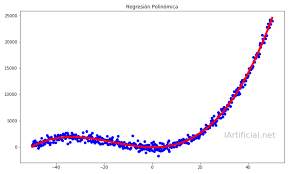


# REGRESIÓN LINEAL CON SKLEARN

Implementamos una regrescion lineal para los infectados con el COVID-19 vamos a importar las librerias que necesitamso para porder derrollar nuestra tarea

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib inline

### Crearemos una funcion

In [2]:
def f(x):
    np.random.seed(42) 
    y = 0.1*x + 1.25 + 0.2*np.random.randn(x.shape[0])
    return y

## Lextura de nuestro  archivo de infectados  de COVID-19 
vamos poner en ceros los datos NAN en cero  para qeu nos nos de un conflicto al momento de  aplicar nuestras regresiones

In [6]:
df = pd.read_csv('owid-covid-data.csv').fillna(0)
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,0.000,0.0,0.0,0.0,...,35973.781,0.0,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
1,ABW,North America,Aruba,2020-03-19,0.0,0.0,0.286,0.0,0.0,0.0,...,35973.781,0.0,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,0.0,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
3,ABW,North America,Aruba,2020-03-21,0.0,0.0,0.286,0.0,0.0,0.0,...,35973.781,0.0,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
4,ABW,North America,Aruba,2020-03-22,0.0,0.0,0.286,0.0,0.0,0.0,...,35973.781,0.0,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54385,0,0,International,2020-10-30,696.0,0.0,0.000,7.0,0.0,0.0,...,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
54386,0,0,International,2020-10-31,696.0,0.0,0.000,7.0,0.0,0.0,...,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
54387,0,0,International,2020-11-01,696.0,0.0,0.000,7.0,0.0,0.0,...,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
54388,0,0,International,2020-11-02,696.0,0.0,0.000,7.0,0.0,0.0,...,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0


## Vamosa filtar por pais  nuestro pais designado es ECUADOR
Filtramos los datos con nuestro pais y  no ceros

In [7]:
Ecuador_df= df.loc[(df['location'] == 'Ecuador') & (df['total_cases'] != 0)] # filtrando por pais y no ceros 
Ecuador_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
14430,ECU,South America,Ecuador,2020-03-01,1.0,1.0,0.143,0.0,0.0,0.000,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752
14431,ECU,South America,Ecuador,2020-03-02,6.0,5.0,0.857,0.0,0.0,0.000,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752
14432,ECU,South America,Ecuador,2020-03-03,7.0,1.0,1.000,0.0,0.0,0.000,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752
14434,ECU,South America,Ecuador,2020-03-05,10.0,3.0,1.429,0.0,0.0,0.000,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752
14435,ECU,South America,Ecuador,2020-03-06,13.0,3.0,1.857,0.0,0.0,0.000,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14673,ECU,South America,Ecuador,2020-10-30,166302.0,1394.0,1407.286,12622.0,14.0,17.429,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752
14674,ECU,South America,Ecuador,2020-10-31,167147.0,845.0,1268.143,12632.0,10.0,14.857,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752
14675,ECU,South America,Ecuador,2020-11-01,168192.0,1045.0,1225.429,12670.0,38.0,18.286,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752
14676,ECU,South America,Ecuador,2020-11-02,169194.0,1002.0,1079.857,12684.0,14.0,18.714,...,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.752


## Vamos a firtrar los datos  que necesitamso  que serian  DATE (Fecha), TOTAL_CASES (total de casos), TOTAL_DEATHS (total de muertes)

In [12]:
dfEcu=Ecuador_df[['date','total_cases','total_deaths']]
dfEcu

,date,total_cases,total_deaths
14430,2020-03-01,1.0,0.0
14431,2020-03-02,6.0,0.0
14432,2020-03-03,7.0,0.0
14434,2020-03-05,10.0,0.0
14435,2020-03-06,13.0,0.0
...,...,...,...
14673,2020-10-30,166302.0,12622.0
14674,2020-10-31,167147.0,12632.0
14675,2020-11-01,168192.0,12670.0
14676,2020-11-02,169194.0,12684.0


In [13]:
nombre =["Fechas", "Total de casos", "Total de muertes"]
dfEcu.columns=nombre
dfEcu.head()


,Fechas,Total de casos,Total de muertes
14430,2020-03-01,1.0,0.0
14431,2020-03-02,6.0,0.0
14432,2020-03-03,7.0,0.0
14434,2020-03-05,10.0,0.0
14435,2020-03-06,13.0,0.0


## Simulamos el numero del dia y el numero de casos de nuetro corpus

In [59]:
x=np.arange(1,len(dfEcu)+1,1)
y=np.array(dfEcu.values[:,1])
y1=np.array(dfEcu.values[:,2])
print("")
print("valores en  y que representan Casos  de contagiados totales por COVID-19")
print("")
print(y)
print("")
print("valores  en y1 representan  Casos de muestos pro  COVID-19  ")
print("")
print(y1)


valores en  y que representan Casos  de contagiados totales por COVID-19

[1.0 6.0 7.0 10.0 13.0 14.0 15.0 17.0 23.0 28.0 37.0 58.0 111.0 168.0
 199.0 426.0 532.0 789.0 981.0 1082.0 1211.0 1403.0 1627.0 1835.0 1890.0
 1966.0 2302.0 2758.0 3163.0 3368.0 3465.0 3646.0 3747.0 3995.0 4450.0
 4965.0 7161.0 7257.0 7466.0 7529.0 7603.0 7858.0 8225.0 8450.0 9022.0
 9468.0 10128.0 10398.0 10850.0 11183.0 11183.0 11183.0 22719.0 23240.0
 24258.0 24675.0 24934.0 26336.0 27464.0 29538.0 31881.0 31881.0 29420.0
 30298.0 28818.0 29071.0 29559.0 29509.0 30419.0 30486.0 30502.0 31467.0
 32763.0 33182.0 33582.0 34151.0 34854.0 35306.0 35828.0 36258.0 36756.0
 37355.0 37355.0 38103.0 38471.0 38571.0 38571.0 39098.0 39994.0 40414.0
 40966.0 40966.0 41575.0 42728.0 43120.0 43378.0 43917.0 44440.0 44440.0
 45778.0 46356.0 46751.0 47322.0 47943.0 48490.0 49097.0 49731.0 50183.0
 50640.0 50640.0 51643.0 52334.0 53156.0 53856.0 54574.0 55255.0 55665.0
 56432.0 58257.0 59468.0 60657.0 61535.0 61958.0 62380.0 

# Hacemos la gráfico de los datos que generamos

In [1]:
plt.plot(x,y,label='Casos', color='blue')
plt.plot(x,y1,label='Muertos', color='red')
plt.axhline(y=0,color="black")
plt.axvline(x=0,color="black")
plt.legend()
plt.title('Grafica de Contagias y muertes de COVID-19');

NameError: name 'plt' is not defined

## Creamos la Regresion Lineal

In [61]:
regresion_lineal = LinearRegression()

## Ingresamos  los datos a aprender

In [62]:
regresion_lineal.fit(x.reshape(-1,1), y) 

LinearRegression()

## Vemos los parámetros que ha estimado la regresión lineal

In [63]:
print('w = ' + str(regresion_lineal.coef_[0]) + ', b = ' + str(regresion_lineal.intercept_))

w = 729.6465842394807, b = -19722.37710437714


In [64]:
if (regresion_lineal.intercept_ < 0):
    ecua='y = {}x {}'
else:
    ecua='y = {}x + {}'
print(ecua.format(regresion_lineal.coef_[0],regresion_lineal.intercept_))

y = 729.6465842394807x -19722.37710437714


## Graficamos la regresion lienal con numero de casos

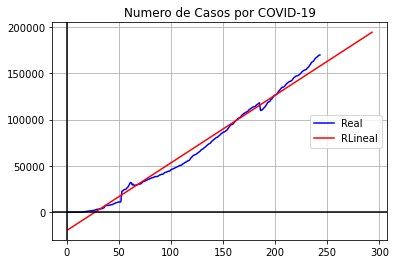

In [71]:
fun= lambda num: regresion_lineal.coef_[0]*num+regresion_lineal.intercept_

plt.plot(x,y,label='Real', color='blue')
plt.grid(True)
plt.title('Numero de Casos por COVID-19');
x1=np.arange(1,len(ndf1)+51,1)
plt.plot(x1,fun(x1),color='red',label='RLineal')
plt.axhline(y=0,color="black")
plt.axvline(x=0,color="black")
plt.legend()
plt.show()

## Vamos a hacer uan regresion lineal para casos de muertes por COVID-19
Creamos una regresion lineal

In [74]:
regresion_lineal = LinearRegression()

## Ingremso lo datos a aprender 

In [75]:
regresion_lineal.fit(x.reshape(-1,1), y1) 

LinearRegression()

## Vemos los parámetros que ha estimado la regresión lineal

In [76]:
print('w = ' + str(regresion_lineal.coef_[0]) + ', b = ' + str(regresion_lineal.intercept_))
print(ecua.format(regresion_lineal.coef_[0],regresion_lineal.intercept_))

w = 57.822256343865895, b = -1818.9531340339436
y = 57.822256343865895x -1818.9531340339436


## Graficamos la Regresion lineal con lso datos generados de muertes

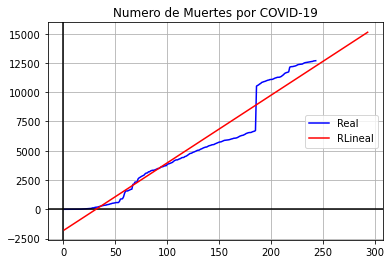

In [78]:
fun= lambda num: regresion_lineal.coef_[0]*num+regresion_lineal.intercept_
plt.plot(x,y1,label='Real', color='blue')
plt.axhline(y=0,color="black")
plt.axvline(x=0,color="black")
plt.grid(True)
plt.title('Numero de Muertes por COVID-19');
x2 = np.arange(1,len(ndf1)+51,1)
plt.plot(x2,fun(x2),color='red',label='RLineal')

plt.legend()
plt.show()

# REGRESION LOGARITMICA

Importamos las librerias que necesitamos para poder realizar nuestra regresion logaritmica

In [79]:
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression

## Creamos un funcion

In [82]:
def modLogistico(x,a,b):
    return a+b*np.log(x)

## Extraemos los valores de los parametros

In [83]:
exp_fit = curve_fit(modLogistico,x,y) 
exp_fit1 = curve_fit(modLogistico,x,y1) 
print(exp_fit)
print("")
print(exp_fit1)

(array([-132282.15628488,   44713.86100596]), array([[ 79233323.69668089, -16815968.22047471],
       [-16815968.22047471,   3730128.57348375]]))

(array([-10481.82124408,   3486.39542592]), array([[ 604709.26516529, -128339.5842676 ],
       [-128339.5842676 ,   28468.36684504]]))


## Predecimos los datos

In [103]:
pred_x = list(range(min(x),max(x)+40))

## Graficamos los valor de los datos numero de casos de infeccion

Text(0, 0.5, 'Personas Infectadas')

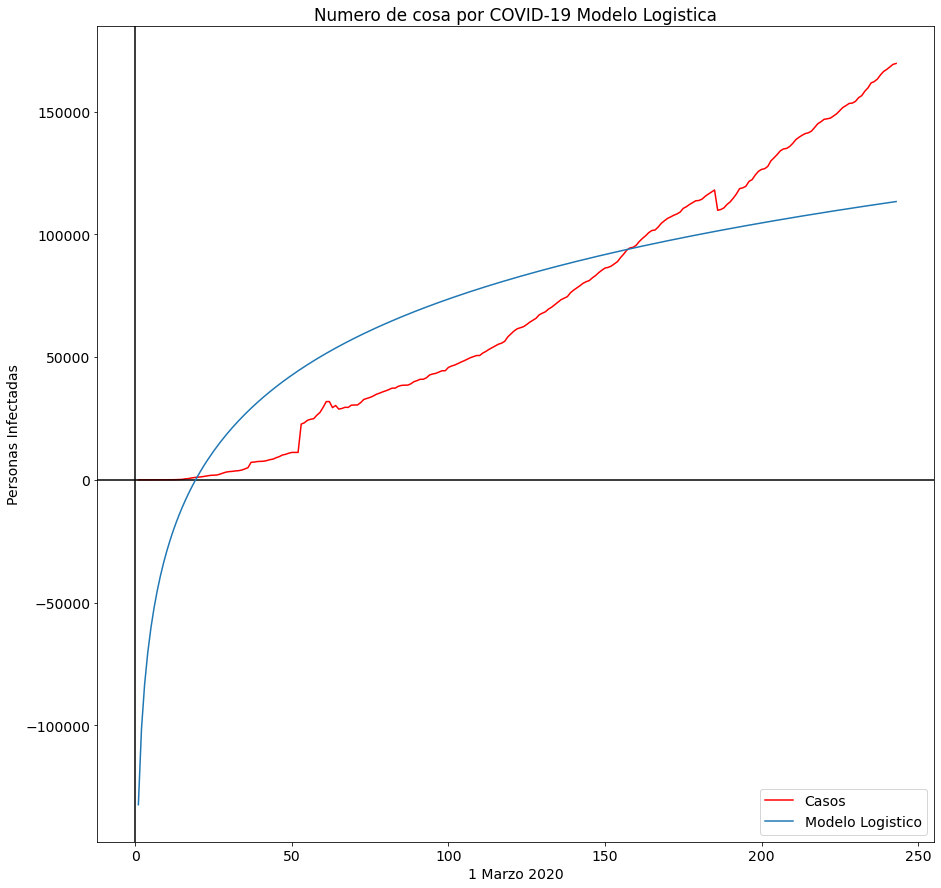

In [110]:
plt.plot(x,y,label="Casos",color="red")
plt.axhline(y=0,color="black")
plt.axvline(x=0,color="black")
plt.title('Numero de cosa por COVID-19 Modelo Logistica');
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("1 Marzo 2020")
plt.ylabel("Personas Infectadas")



## Graficamos los valor de los datos numero de muertes por infeccion de COVID-19

Text(0, 0.5, 'Personas Muertas')

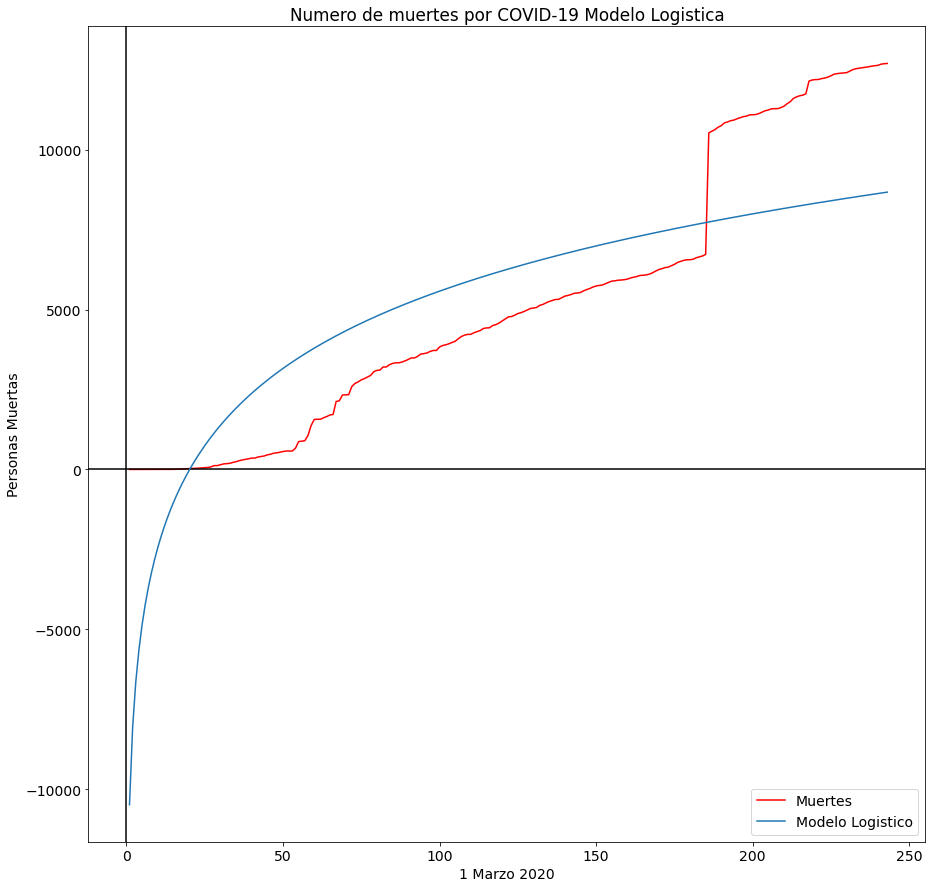

In [122]:
plt.plot(x,y1,label="Muertes",color="red")
plt.axhline(y=0,color="black")
plt.axvline(x=0,color="black")
plt.title('Numero de muertes por COVID-19 Modelo Logistica');
plt.plot(pred_x, [modelo_logistico(i,exp_fit1[0][0],exp_fit1[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("1 Marzo 2020")
plt.ylabel("Personas Muertas")



# Analisis
Como podemos ver se a realizado las dos regresiones, las dos son muy eficientes para el calculo, por ello una de ellas es mejor para las prediccion y es la "Regresion Lineal", nos ayuda de mejor forma con la prediccion, a resolver el problema en el tiempo determinado, la regresion logaritmica no esta al alcanse de predecir en el tiempo determinado, si no es una prediccion en un tiempo lejano.

# Conclusion

Como conclusion podemos decir que las regresiones son metodos matematicos que se usan para las aproximacion de relaciónes de dependencia entre una variable dependiente y variables independientes, estos metos puedeser aplicados a problemas del mundo real y cada modelo  tiene una enfacis mejor que el otro


## Criterio personal (politico, economico y  social de la situacion)
A mi parece en la parte politica las personas vivimos en un mundo donde todo es fraude y robos, de modo que  nuestro pais no esta capacitado para soportar un tipo de pandamia que se esta viviendo, es una mala administracion de parte del las personas que estan acargo, y economia de nuetro pais a decaido mucho mas y estamos en una cris economica que se a visto regrejada en la sociedad por la falta de empleo las personas tiene que buscar de otra formas el ingreso economico 


# Referencias

- https://www.paho.org/es/temas/rotavirus
- https://elpais.com/noticias/infecciones/

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia
